In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import copy

In [7]:
### RESETTING IMAGE RESOLUTION

umpp = 0.91 # um per pixel
time_i = 0 # initial time point in hr
time_f = 23 # final time point in hr
path = "deconv_s1t" # file name until timestamp
fc = "Cy3" # fluorescent channel name

nump = 50 # number of pixels to combine when resizing

# Import images

Phase = []
FC = []

t = time_i+1

im = np.array(Image.open(path+str(t).zfill(2)+"_Phase.jpg").convert('L'))
Ly = len(im)
Lx = len(im[0])

Ly_new = int(Ly/nump)
Lx_new = int(Lx/nump)

size = Lx_new, Ly_new

def resolve_down(im, factor):
    Lx, Ly = im.size
    
    LR_off = Lx%factor
    L_off = int(LR_off/2)
    R_off = Lx-LR_off+L_off
    TB_off = Ly%factor
    T_off = int(TB_off/2)
    B_off = Ly-TB_off+T_off
    
    im1 = np.array(im.crop((L_off, T_off, R_off, B_off)))
    
    new = []
    for a in im1:
        b = a.reshape(-1, factor).mean(axis=1)
        new.append(b)
    new = np.array(new).T
    neww = []
    for a in new:
        b = a.reshape(-1, factor).mean(axis=1)
        neww.append(b)
    newww = np.array(neww).T
    
    return newww

while t<time_f:
    imp = Image.open(path+str(t).zfill(2)+"_Phase.jpg").convert('L')
    imp_resized = resolve_down(imp, nump)
    #imp_resized = np.array(imp.resize(size, Image.ANTIALIAS)).astype(np.float32)
    imf = Image.open(path+str(t).zfill(2)+"_{}.jpg".format(fc)).convert('L')
    imf_resized = resolve_down(imf, nump)
    #imf_resized = np.array(imf.resize(size, Image.ANTIALIAS)).astype(np.float32)
    
    Phase.append(imp_resized)
    FC.append(imf_resized)
    t+=1
    
Phase = np.array(Phase)
FC = np.array(FC)

In [8]:
def grad_vec_field(series, t, Lx, Ly, dx):

    xr = np.arange(0, Ly*dx, dx)
    yr = np.arange(0, Lx*dx, dx)

    # Create grid corresponding to xr and yr arrays
    xx, yy = np.meshgrid (xr, yr, indexing = 'ij')

    zz1 = series[t+1]
    gradx1, grady1 = np.gradient(zz1, dx, dx)

    zz0 = series[t]
    gradx0, grady0 = np.gradient (zz0, dx, dx)
    
    return(xx, yy, gradx1-gradx0, grady1-grady0)

def plot_vec_field(series, t, Lx, Ly, dx):
    
    xx, yy, Dx, Dy = grad_vec_field(series, t, Lx, Ly, dx)

    fig = plt.figure(constrained_layout=True, figsize=(15,8))
    axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})
    
    TB = axs['TopRight'].imshow(-Dx, cmap='coolwarm')
    axs['TopRight'].set_title('Y component of ascent rate')
    fig.colorbar(TB, ax=axs['TopRight'])
    
    LR = axs['BottomRight'].imshow(Dy, cmap='coolwarm')
    axs['BottomRight'].set_title('X component of ascent rate')
    fig.colorbar(LR, ax=axs['BottomRight'])
    
    skip = (slice(None, None, 2), slice(None, None, 2))

    axs['Left'].quiver(yy[skip], np.flip(xx)[skip], Dy[skip] , -Dx[skip],
                      color='black', headwidth=5, scale=1, headlength=5)
    

In [9]:
## MODEL PARAMETERS

# Cell
mu = 0.35/3600        # max growth rate of strain 1 (in 1/sec)
Qhf = 70           # cell density for half pressure (in g/mL dcw)
Phf = 70           # cell density for half acceptance (in g/mL dcw)
Y = 400               # biomass yield (in g biomass/g glucose)

# Glucose
Ks = 4*10**-3         # rate of nutrient consumption by Monod kinetics (in g/mL)

# Diffusion
DC = 1200              # spreading coefficient of cells (in um^2)
DS = 200              # diffusion coefficient of glucose (in um^2/sec)

# Initial condition
S0 = 0.4            # glucose concentration in feed medium (in g/mL)

# Time Resolution in sec
dt = 1
# Time steps
T = 79200

dx= nump*umpp
res = dt/dx**2 

print("Simulation time is", dt*T, "seconds \n dt =", dt, "seconds")
print("dt / dx^2 = ", res)

Simulation time is 79200 seconds 
 dt = 1 seconds
dt / dx^2 =  0.0004830334500664171


In [10]:
## MODEL FUNCTIONS

def nbr_sum(M):
    """Get the discrete Laplacian of matrix M"""
    L = np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += nbr_sum(M)
    
    return L

def divide(M1,M2):
    """To divide two numpy arrays M1/M2 element-wise and avoide division by zero"""
    f = np.divide(M1, M2, out=np.zeros_like(M1), where=M2!=0)
    return f

def q(C, Qhf):
    Q = C/(Qhf+C)
    return Q

def p(M, Phf):
    P = Phf/(Phf+C)
    return P

def update(C, S, Qhf, Phf):
    
    Q = q(C, Qhf)
    P = p(C, Phf)
    
    Sdiff = res*DS*discrete_laplacian(S) - dt*mu*C*divide(S,Y*(Ks+S))
    Cdiff = dt*mu*(1-Q)*C*S/(Ks+S) + res*DC*mu*(P*nbr_sum(C*Q*S/(Ks+S)) - Q*C*S*nbr_sum(P)/(Ks+S))
    
    C += Cdiff
    S += Sdiff
    # Remove negative values\
    S[S < 0] = 0 
    
    # Reflecting boundaries
    
    C[0,:], S[0,:] = C[1,:], S[1,:]          # top
    C[-1,:], S[-1,:] = C[-2,:], S[-2,:] # bottom
    C[:,0], S[:,0] = C[:,1], S[:,1]         # left
    C[:,-1], S[:,-1] = C[:,-2], S[:,-2]  # right
                            
    return C, S

In [11]:
# Initialize
C = copy.deepcopy(FC[0])
C-=1
C[C<0]=0
S = np.ones((Ly_new,Lx_new))*S0

# Simulate

update_every = 3600 # number of time steps after which data is stored
C_time = []
S_time = []

start = time.time()

for tt in range(T):
    if tt%update_every == 0:
        C_time.append(C.copy())
        S_time.append(S.copy())
    C, S = update(C, S, Qhf, Phf)

stop = time.time()

print("end of simultaion. Time taken = {} seconds".format(stop-start))

end of simultaion. Time taken = 76.47999930381775 seconds


Text(0, 0.5, 'Intensity')

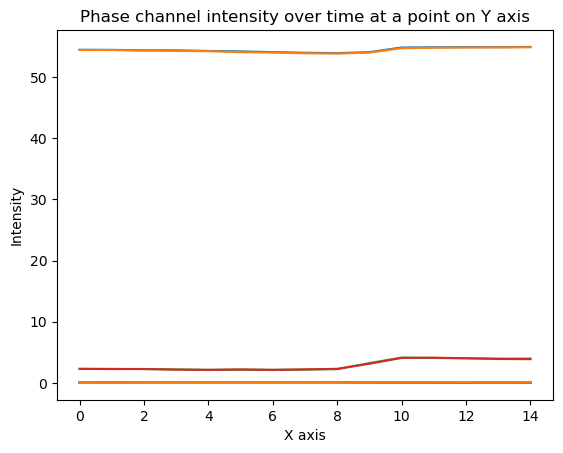

In [12]:
for i in FC:
    plt.plot(i[40][15:30])  #[15:30]
    
plt.title('Phase channel intensity over time at a point on Y axis')
plt.xlabel('X axis')
plt.ylabel('Intensity')

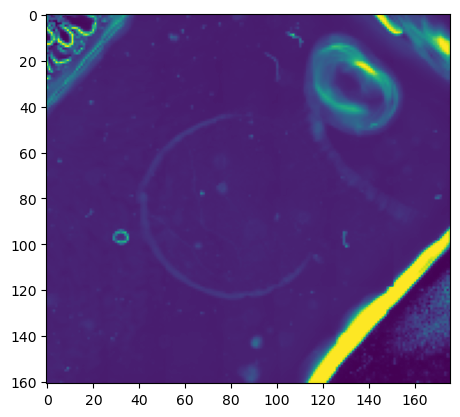

In [13]:
plt.imshow(Phase[0])

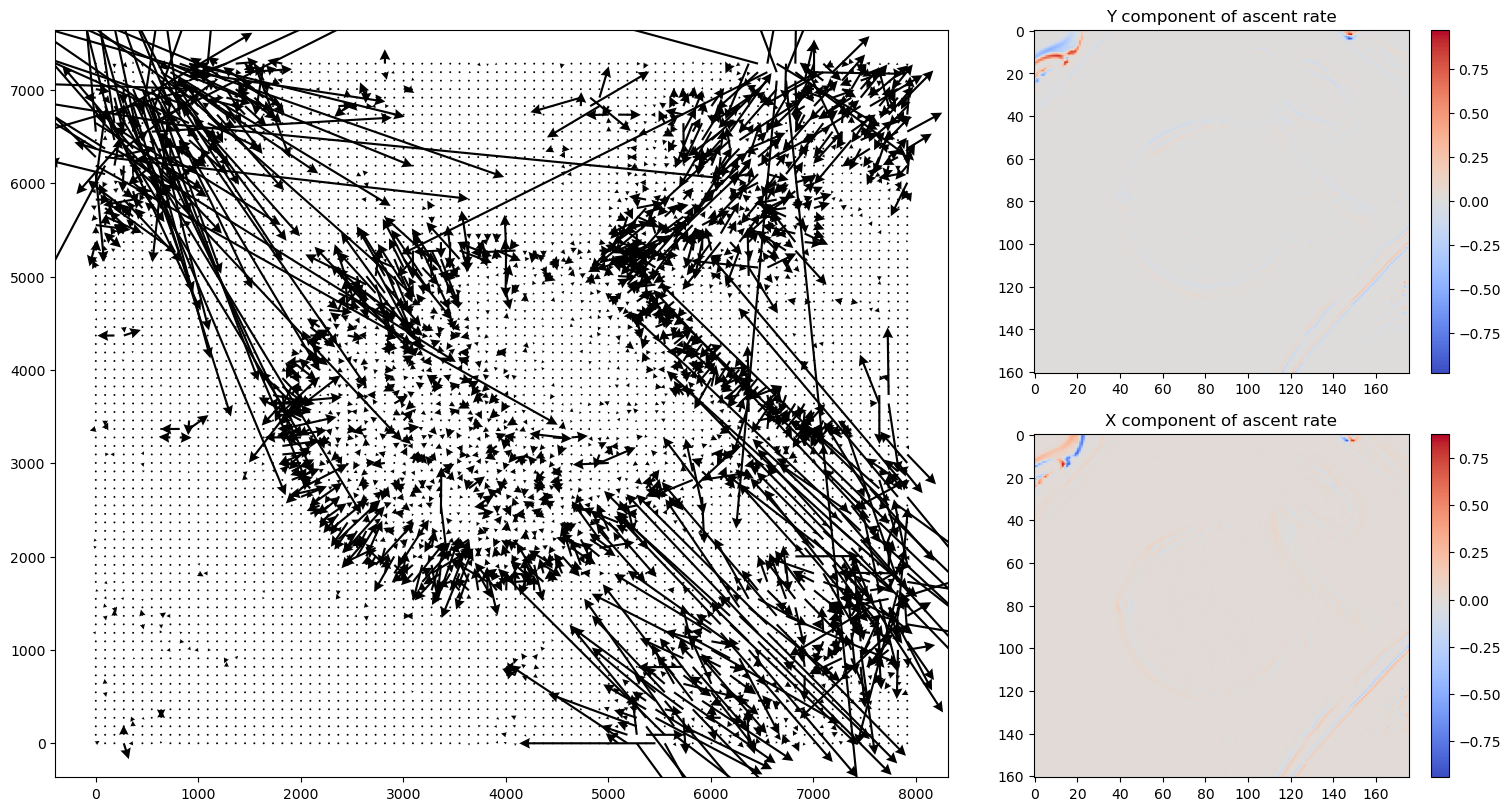

In [14]:
## RATE OF GRADIENT ASCENT
plot_vec_field(Phase, 10, Lx_new, Ly_new, dx)

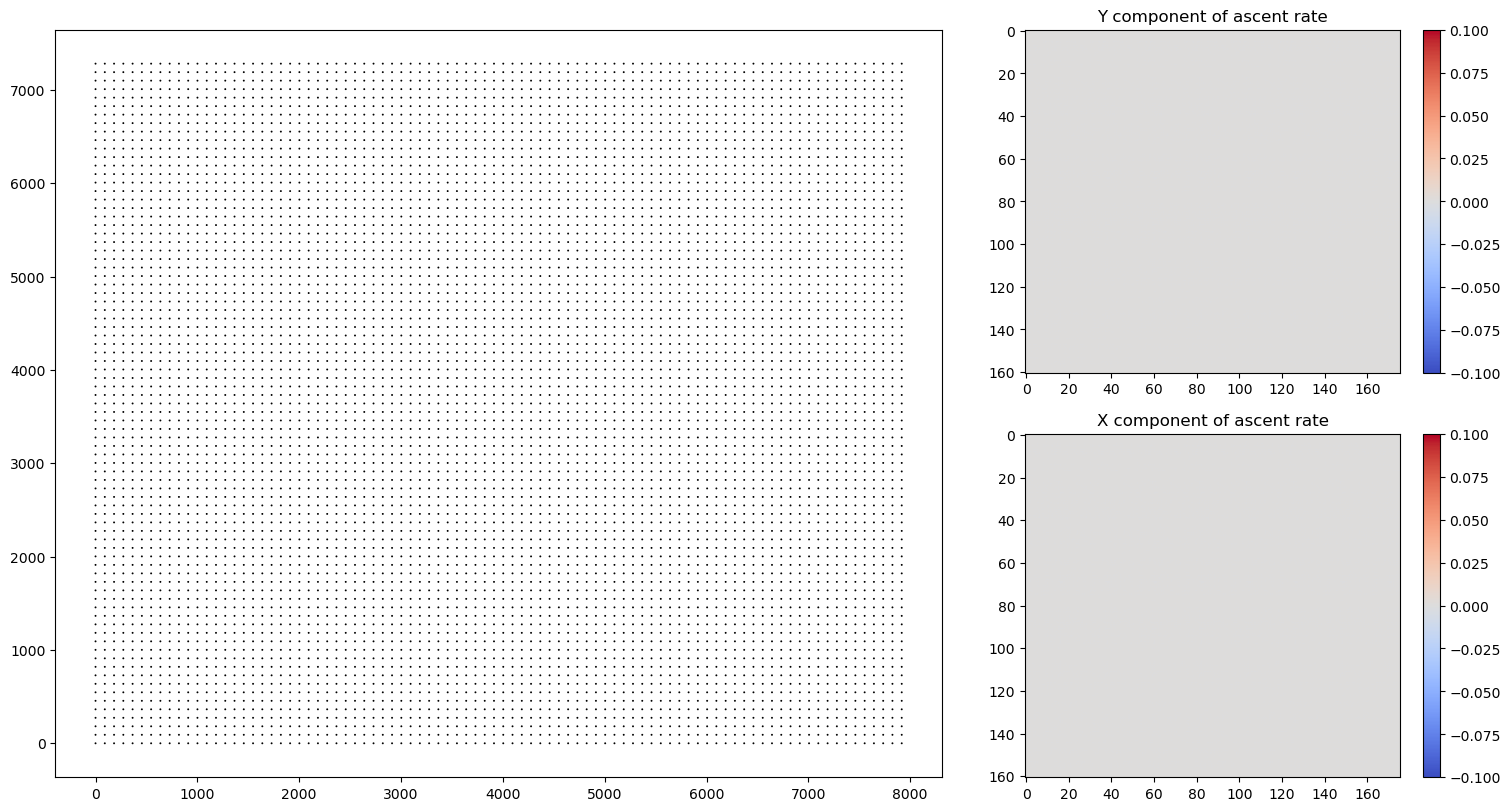

In [15]:
plot_vec_field(C_time, 10, Lx_new, Ly_new, dx)

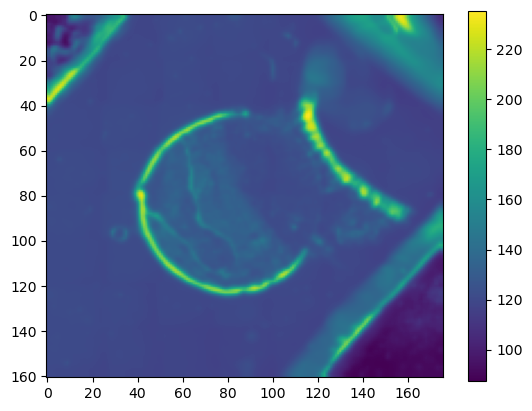

In [16]:
plt.imshow(C_time[19])
plt.colorbar()

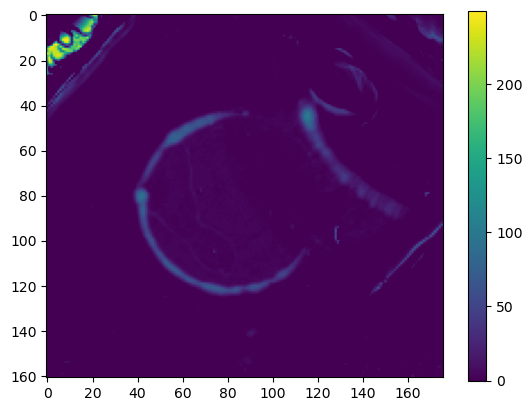

In [16]:
plt.imshow(Phase[13]-Phase[0], vmin=0)
plt.colorbar()

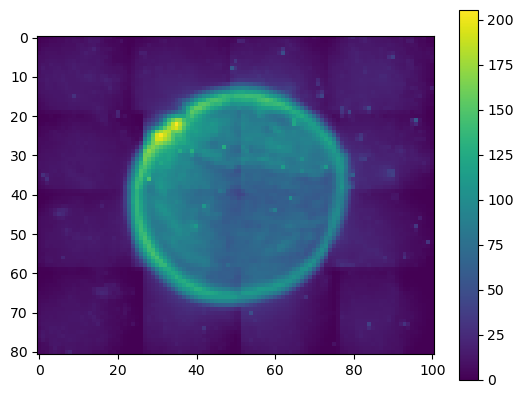

In [ ]:
plt.imshow(Phase[13])
plt.colorbar()

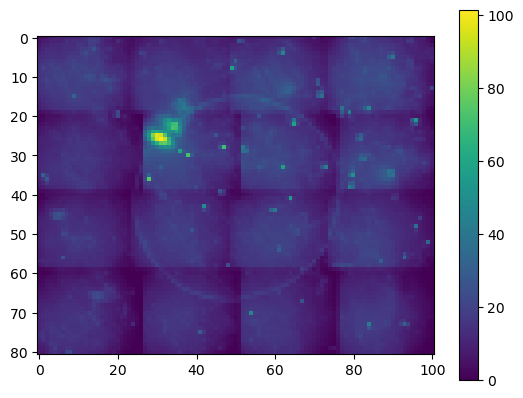

In [ ]:
plt.imshow(Phase[0])
plt.colorbar()

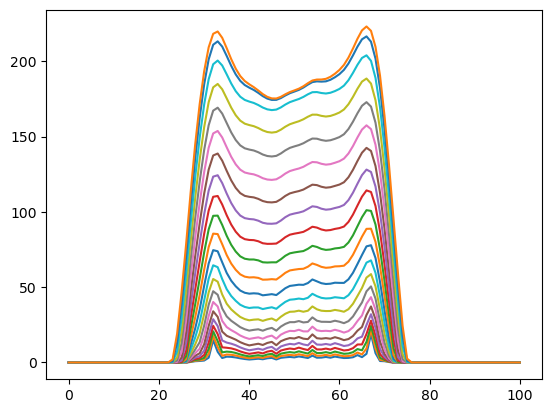

In [ ]:
for i in C_time:
    plt.plot(i[60])

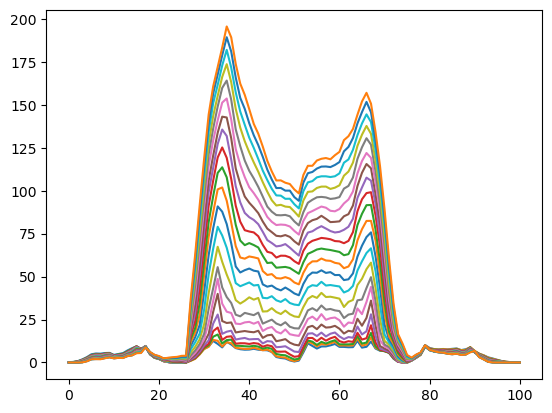

In [ ]:
for i in Phase:
    plt.plot(i[60])

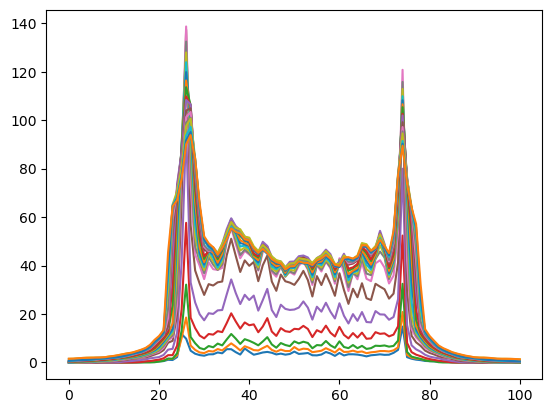

In [ ]:
for i in FC:
    plt.plot(i[50])

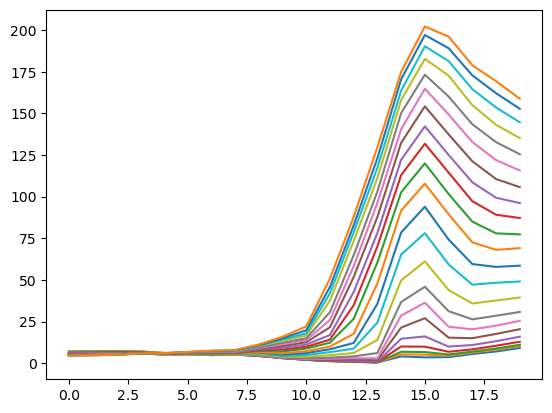

In [ ]:
for i in Phase:
    plt.plot(i[40][10:30])

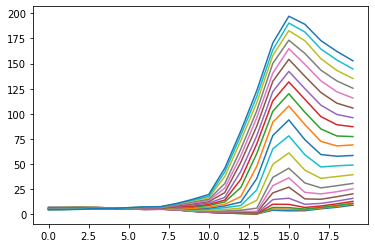

In [ ]:
error = []

t = time_i+1

while t<time_f:
    xx, yy, DxO, DyO = grad_vec_field(Phase, t, Lx_new, Ly_new, dx)
    xx, yy, DxP, DyP = grad_vec_field(C_time, t, Lx_new, Ly_new, dx)
    
    err_arr = (DxP-DxO)**2 + (DyP-DyO)**2 
    err = np.sum(err_arr)
    error.append(err)
    t+=1

NameError: name 'time_i' is not defined

Text(0.5, 0, 'time')

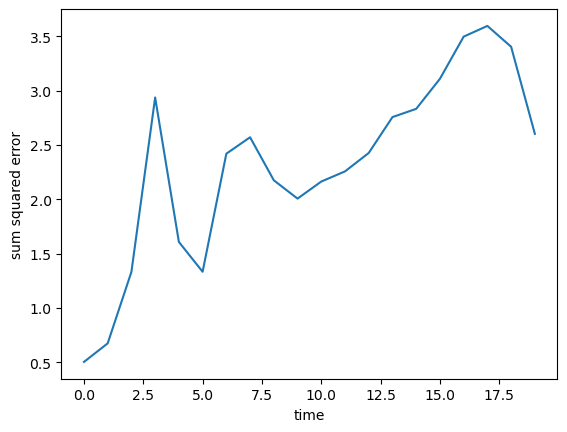

In [ ]:
plt.plot(error)
plt.ylabel('sum squared error')
plt.xlabel('time')

In [ ]:
array = np.array([[1,2,6],
                  [2,0,8],
                  [8,10,3]])

In [ ]:
gx, gy = np.gradient(array,1,1)

In [ ]:
gx

array([[ 1. , -2. ,  2. ],
       [ 3.5,  4. , -1.5],
       [ 6. , 10. , -5. ]])

In [ ]:
gy

array([[ 1. ,  2.5,  4. ],
       [-2. ,  3. ,  8. ],
       [ 2. , -2.5, -7. ]])

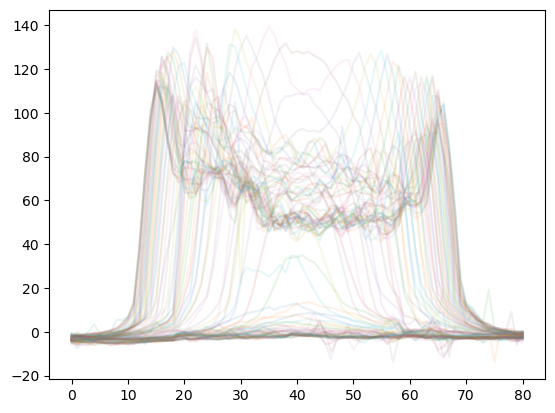

In [ ]:
t = 13
x = 44
plt.plot(Phase[t]-Phase[0], alpha=0.1)

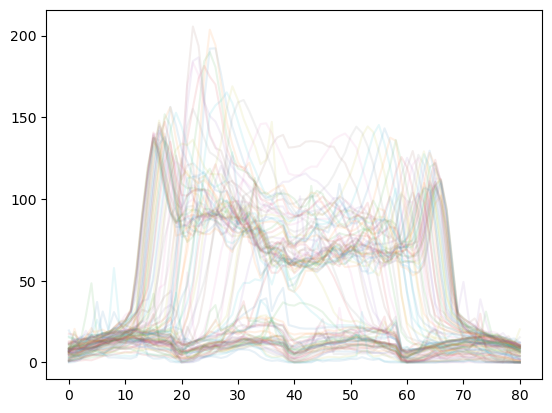

In [ ]:
plt.plot(Phase[t], alpha=0.1)

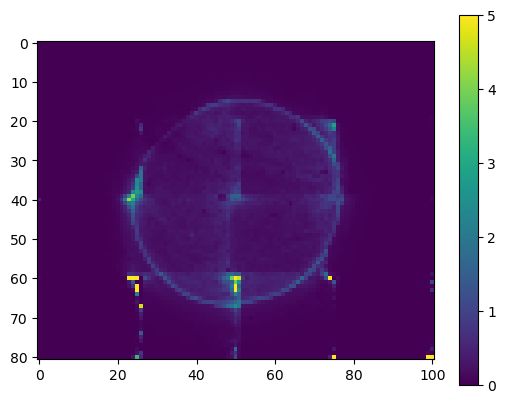

In [ ]:
plt.imshow(divide(FC[0],Phase[0]), vmax=5)
plt.colorbar()